In [2890]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np
from sklearn.metrics import recall_score, precision_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2891]:
def my_round(num, n):
    x = num * 10**n
    d = x - x.astype('int')
    return np.where((d>=0.5) | ((d>-0.5) & (d <=0)), np.ceil(x), np.floor(x)) / 10**n

In [2892]:
user = pd.read_csv('user.csv')
user_decision = pd.read_csv('user_decision.csv')
team_point = pd.read_csv('team_point.csv')
df = pd.read_csv('train_dataset_train.csv')
decision = pd.read_excel('decision.xlsx', sheet_name = 'decision')
sample_solution = pd.read_csv('sample_solution.csv')

## Знакомство с данными, проверка

In [2893]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  973 non-null    int64
 1   team_id  973 non-null    int64
 2   game_id  973 non-null    int64
dtypes: int64(3)
memory usage: 22.9 KB


In [2894]:
user.head()

,user_id,team_id,game_id
0,10189,1664,235
1,10018,1690,237
2,10580,1394,194
3,10600,1908,262
4,10112,1592,219


Посмотреть количество уникальных значений игроков, команд, игр

In [2895]:
user[user.columns].apply(lambda x: x.nunique())

user_id    973
team_id    214
game_id     43
dtype: int64

Посмотреть группировки по играм и командам

In [2896]:
user_decision.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60228 entries, 0 to 60227
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      60228 non-null  int64
 1   period       60228 non-null  int64
 2   decision_id  60228 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


In [2897]:
user_decision.head()

,user_id,period,decision_id
0,10625,1,409
1,10318,3,203
2,10775,4,420
3,10236,2,284
4,10130,3,72


In [2898]:
user_decision[user_decision.columns].apply(lambda x: x.nunique())

user_id        973
period           4
decision_id    343
dtype: int64

In [2899]:
user_decision.period.value_counts()

3    20964
4    14811
2    14453
1    10000
Name: period, dtype: int64

In [2900]:
len(set(user['user_id']) ^ set(user_decision['user_id']))

0

In [2901]:
len(set(user['team_id']) ^ set(team_point['team_id']))

141

In [2902]:
team_point['team_id'].nunique()

355

In [2903]:
user['team_id'].nunique()

214

In [2904]:
len(set(user['user_id']) & set(df['id']))

680

In [2905]:
len(set(user['user_id']) & set(sample_solution['id']))

293

In [2906]:
len(set(user_decision['decision_id']) & set(decision['decision_id']))

343

In [2907]:
decision.head()

,decision_id,decision_name
0,1,Dividend payout in cash
1,2,Dividend payout in stocks
2,3,Zero dividend policy
3,4,The distribution of the residue after the rein...
4,5,Fixed size of dividend payouts sum


Посмотреть группировки по периодам и решениям

In [2908]:
user_decision.groupby('user_id')['decision_id'].count().mean()

61.89928057553957

In [2909]:
df.head()

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10884,4.00,4.00,4.00,4.00
1,10106,5.00,4.00,5.00,5.00
2,10438,6.00,5.00,5.00,5.00
3,10130,5.00,4.00,5.00,5.00
4,10667,4.00,5.00,5.00,5.00


In [2910]:
df['id'].nunique()

680

In [2911]:
df.describe()

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
count,680.00,680.00,680.00,680.00,680.00
mean,"10,486.09",4.28,4.12,4.45,4.31
std,281.74,0.65,0.60,0.66,0.61
min,"10,001.00",1.00,1.00,1.00,1.00
25%,"10,233.75",4.00,4.00,4.00,4.00
50%,"10,491.50",4.00,4.00,4.00,4.00
75%,"10,729.25",5.00,4.00,5.00,5.00
max,"10,973.00",6.00,6.00,6.00,6.00


In [2912]:
sample_solution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   id                   293 non-null    int64
 1   Analytical thinking  293 non-null    int64
 2   Systemic thinking    293 non-null    int64
 3   Adaptability         293 non-null    int64
 4   Focus                293 non-null    int64
dtypes: int64(5)
memory usage: 11.6 KB


In [2913]:
sample_solution['id'].nunique()

293

In [2914]:
team_point.head()

,team_id,category_id,period,score,place
0,1948,2,0,16,2
1,1934,3,4,45,6
2,1894,4,8,24,4
3,1688,4,0,27,4
4,1592,4,2,21,5


In [2915]:
team_point['team_id'].nunique()

355

**Анализ score по командам**

In [2916]:
team = team_point[team_point['team_id'].isin(user['team_id'])]

In [2917]:
team.head()

,team_id,category_id,period,score,place
3,1688,4,0,27,4
4,1592,4,2,21,5
5,1344,5,0,8,6
7,1460,2,2,-29,6
9,1848,3,1,62,5


In [2918]:
team = team[team['period']<5].reset_index()

<AxesSubplot:>

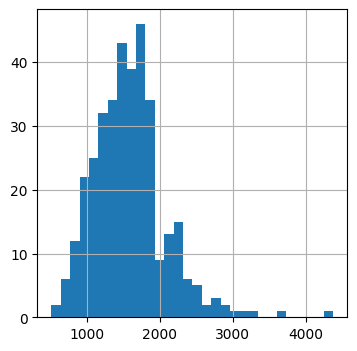

In [2919]:
team_score_0 = pd.DataFrame(team_point.groupby('team_id')['score'].sum())
team_point.groupby('team_id')['score'].sum().hist(bins=30, figsize = (4,4))

In [2920]:
team_score_0.describe()

,score
count,355.00
mean,"1,585.49"
std,496.25
min,516.00
25%,"1,251.00"
50%,"1,554.00"
75%,"1,817.00"
max,"4,376.00"


array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

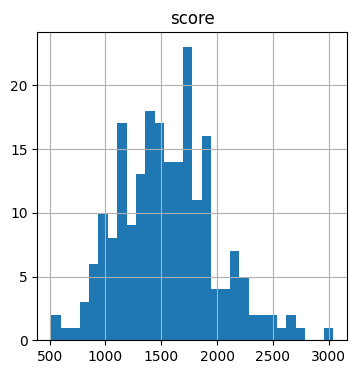

In [2921]:
team_score = pd.DataFrame(team.groupby('team_id')['score'].sum())
team_score.hist(bins=30, figsize = (4,4))
#team_score.query('score < 1000').hist(bins=30)

In [2922]:
team_score.describe()

,score
count,214.00
mean,"1,556.01"
std,428.67
min,516.00
25%,"1,250.50"
50%,"1,552.00"
75%,"1,799.50"
max,"3,040.00"


После сокращения числа периодов распределение score изменилось незначительно

In [2923]:
print(team_score.index.nunique())

214


In [2924]:
team_game = user.drop('user_id', axis=1).drop_duplicates()
#team_game = user.drop_duplicates()

In [2925]:
team_game.nunique()

team_id    214
game_id     43
dtype: int64

**Анализ величины score команд по разным играм**

In [2926]:
team = team.set_index('team_id').join(team_game.set_index('team_id')).reset_index()

In [2927]:
team.head(1)

,team_id,index,category_id,period,score,place,game_id
0,1248,629,5,2,24,1,182


In [2928]:
team['total_score']=team.groupby('team_id')['score'].transform('sum')

In [2929]:
team.head(1)

,team_id,index,category_id,period,score,place,game_id,total_score
0,1248,629,5,2,24,1,182,2698


In [2930]:
team = team.set_index('team_id').join(user.drop('game_id', axis=1).set_index('team_id'), how = 'right').reset_index()

In [2931]:
team.head(1)

,team_id,index,category_id,period,score,place,game_id,total_score,user_id
0,1248,629,5,2,24,1,182,2698,10273


In [2932]:
for i in [1, 2, 3, 4, 5, 6]:
    col_name = 'cat_'+ str(i)
    team[col_name] = team[team['category_id'] == i].groupby(['user_id'])['score'].transform('sum')

In [2933]:
team.head()

,team_id,index,category_id,period,score,place,game_id,total_score,user_id,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6
0,1248,629,5,2,24,1,182,2698,10273,NaN,NaN,NaN,NaN,133.00,NaN
1,1248,1537,5,0,8,1,182,2698,10273,NaN,NaN,NaN,NaN,133.00,NaN
2,1248,1700,4,2,44,1,182,2698,10273,NaN,NaN,NaN,235.00,NaN,NaN
3,1248,3504,1,4,68,1,182,2698,10273,178.00,NaN,NaN,NaN,NaN,NaN
4,1248,3601,6,4,354,1,182,2698,10273,NaN,NaN,NaN,NaN,NaN,"1,349.00"


In [2934]:
team.shape

(29190, 15)

In [2935]:
team = team.groupby('user_id').max()

In [2936]:
team.head()

,team_id,index,category_id,period,score,place,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6
user_id,,,,,,,,,,,,,,
10001,1366,10943,6,4,328,5,192,2408,183.00,147.00,524.00,183.00,167.00,"1,204.00"
10002,1682,10250,6,4,299,6,236,2294,149.00,224.00,485.00,200.00,89.00,"1,147.00"
10003,1652,10872,6,4,158,6,234,744,-67.00,-135.00,312.00,101.00,161.00,372.00
10004,1472,10267,6,4,158,6,206,1094,-21.00,-9.00,327.00,107.00,143.00,547.00
10005,1602,10632,6,4,158,6,219,900,-42.00,-64.00,319.00,117.00,120.00,450.00


In [2937]:
team.shape

(973, 14)

In [2938]:
team_game_score = team.drop(['category_id','period','score','place', 'index'], axis=1).drop_duplicates()

In [2939]:
team_game_score.head(1)

,team_id,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6
user_id,,,,,,,,,
10001,1366,192,2408,183.00,147.00,524.00,183.00,167.00,"1,204.00"


In [2940]:
team_game_score['total_score'].describe()

count     214.00
mean    1,556.01
std       428.67
min       516.00
25%     1,250.50
50%     1,552.00
75%     1,799.50
max     3,040.00
Name: total_score, dtype: float64

In [2941]:
min_score_game = team_game_score.groupby('game_id')['total_score'].min()
max_score_game = team_game_score.groupby('game_id')['total_score'].max()
mean_score_game = team_game_score.groupby('game_id')['total_score'].mean()

In [2942]:
min_score_game.describe()

count      43.00
mean    1,122.19
std       320.05
min       516.00
25%       923.00
50%     1,072.00
75%     1,259.00
max     1,884.00
Name: total_score, dtype: float64

Text(0, 0.5, '')

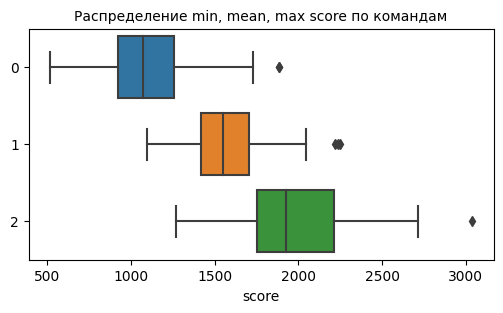

In [2943]:
plt.figure(figsize = (6,3))
sns.boxplot(data=[min_score_game, mean_score_game, max_score_game],
                 orient="h")
plt.title('Распределение min, mean, max score по командам', fontsize = 10)
plt.xlabel('score')
plt.ylabel('')

In [2944]:
user_score = team_game_score.set_index('team_id').join(user.set_index('team_id').drop('game_id', axis=1), how = 'right')

In [2945]:
user_score.head(1)

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,user_id
team_id,,,,,,,,,
1248,182,2698,178.00,297.00,506.00,235.00,133.00,"1,349.00",10273


In [2946]:
user_score['max_score']=user_score.groupby('game_id')['total_score'].transform('max')
user_score.head(5)

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,user_id,max_score
team_id,,,,,,,,,,
1248,182,2698,178.00,297.00,506.00,235.00,133.00,"1,349.00",10273,2698
1248,182,2698,178.00,297.00,506.00,235.00,133.00,"1,349.00",10762,2698
1248,182,2698,178.00,297.00,506.00,235.00,133.00,"1,349.00",10646,2698
1252,182,1312,-1.00,27.00,405.00,152.00,73.00,656.00,10547,2698
1252,182,1312,-1.00,27.00,405.00,152.00,73.00,656.00,10833,2698


In [2947]:
user_score['score_rating']= user_score['total_score']/user_score['max_score']
user_score.head(1)

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,user_id,max_score,score_rating
team_id,,,,,,,,,,,
1248,182,2698,178.00,297.00,506.00,235.00,133.00,"1,349.00",10273,2698,1.00


In [2948]:
for i in [1, 2, 3, 4, 5, 6]:
    col_name = 'rating_'+ str(i)+'_max'
    col_name_cat = 'cat_'+str(i)
    user_score[col_name] = user_score.groupby('game_id')[col_name_cat].transform('max')

In [2949]:
user_score.head(5)

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,user_id,max_score,score_rating,rating_1_max,rating_2_max,rating_3_max,rating_4_max,rating_5_max,rating_6_max
team_id,,,,,,,,,,,,,,,,,
1248,182,2698,178.00,297.00,506.00,235.00,133.00,"1,349.00",10273,2698,1.00,178.00,297.00,506.00,235.00,133.00,"1,349.00"
1248,182,2698,178.00,297.00,506.00,235.00,133.00,"1,349.00",10762,2698,1.00,178.00,297.00,506.00,235.00,133.00,"1,349.00"
1248,182,2698,178.00,297.00,506.00,235.00,133.00,"1,349.00",10646,2698,1.00,178.00,297.00,506.00,235.00,133.00,"1,349.00"
1252,182,1312,-1.00,27.00,405.00,152.00,73.00,656.00,10547,2698,0.49,178.00,297.00,506.00,235.00,133.00,"1,349.00"
1252,182,1312,-1.00,27.00,405.00,152.00,73.00,656.00,10833,2698,0.49,178.00,297.00,506.00,235.00,133.00,"1,349.00"


In [2950]:
for i in [1, 2, 3, 4, 5, 6]:
    col_name = 'rating_'+ str(i)+'_max'
    col_name_cat = 'cat_'+str(i)
    col_name_rating = 'rating_'+str(i)
    user_score[col_name_rating] = user_score[col_name_cat] / user_score[col_name]

In [2951]:
user_score.head(5)

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,user_id,max_score,...,rating_3_max,rating_4_max,rating_5_max,rating_6_max,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
team_id,,,,,,,,,,,,,,,,,,,,,
1248,182,2698,178.00,297.00,506.00,235.00,133.00,"1,349.00",10273,2698,...,506.00,235.00,133.00,"1,349.00",1.00,1.00,1.00,1.00,1.00,1.00
1248,182,2698,178.00,297.00,506.00,235.00,133.00,"1,349.00",10762,2698,...,506.00,235.00,133.00,"1,349.00",1.00,1.00,1.00,1.00,1.00,1.00
1248,182,2698,178.00,297.00,506.00,235.00,133.00,"1,349.00",10646,2698,...,506.00,235.00,133.00,"1,349.00",1.00,1.00,1.00,1.00,1.00,1.00
1252,182,1312,-1.00,27.00,405.00,152.00,73.00,656.00,10547,2698,...,506.00,235.00,133.00,"1,349.00",-0.01,0.09,0.80,0.65,0.55,0.49
1252,182,1312,-1.00,27.00,405.00,152.00,73.00,656.00,10833,2698,...,506.00,235.00,133.00,"1,349.00",-0.01,0.09,0.80,0.65,0.55,0.49


In [2952]:
user_score.columns

Index(['game_id', 'total_score', 'cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5',
       'cat_6', 'user_id', 'max_score', 'score_rating', 'rating_1_max',
       'rating_2_max', 'rating_3_max', 'rating_4_max', 'rating_5_max',
       'rating_6_max', 'rating_1', 'rating_2', 'rating_3', 'rating_4',
       'rating_5', 'rating_6'],
      dtype='object')

In [2953]:
col_drop = ['max_score', 'rating_1_max', 'rating_2_max', 'rating_3_max', 'rating_4_max', 'rating_5_max', 'rating_6_max']

In [2954]:
user_score = user_score.drop(col_drop, axis=1).set_index('user_id')

In [2955]:
user_score.head(5)

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
user_id,,,,,,,,,,,,,,,
10273,182,2698,178.00,297.00,506.00,235.00,133.00,"1,349.00",1.00,1.00,1.00,1.00,1.00,1.00,1.00
10762,182,2698,178.00,297.00,506.00,235.00,133.00,"1,349.00",1.00,1.00,1.00,1.00,1.00,1.00,1.00
10646,182,2698,178.00,297.00,506.00,235.00,133.00,"1,349.00",1.00,1.00,1.00,1.00,1.00,1.00,1.00
10547,182,1312,-1.00,27.00,405.00,152.00,73.00,656.00,0.49,-0.01,0.09,0.80,0.65,0.55,0.49
10833,182,1312,-1.00,27.00,405.00,152.00,73.00,656.00,0.49,-0.01,0.09,0.80,0.65,0.55,0.49


In [2956]:
df.head(1)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10884,4.00,4.00,4.00,4.00


In [2957]:
df_score = df.set_index('id').join(user_score, how = 'left')

In [2958]:
df_score.head()

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
id,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,1188,-5.00,-25.00,391.00,128.00,105.00,594.00,0.55,-0.04,-0.13,0.77,0.74,1.00,0.55
10106,5.00,4.00,5.00,5.00,211,1828,54.00,120.00,467.00,160.00,113.00,914.00,1.00,1.00,0.90,0.99,0.90,1.00,1.00
10438,6.00,5.00,5.00,5.00,242,1604,55.00,60.00,383.00,158.00,146.00,802.00,1.00,1.00,0.69,0.98,1.00,0.81,1.00
10130,5.00,4.00,5.00,5.00,184,1334,31.00,24.00,366.00,139.00,107.00,667.00,0.62,0.30,0.12,0.71,0.69,1.00,0.62
10667,4.00,5.00,5.00,5.00,193,1756,71.00,70.00,416.00,166.00,155.00,878.00,0.72,0.41,0.26,0.97,0.80,0.87,0.72


In [2959]:
df_score.drop('game_id', axis=1).corr()

,Analytical thinking,Systemic thinking,Adaptability,Focus,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
Analytical thinking,1.00,0.56,0.55,0.54,0.16,0.15,0.18,0.10,0.16,-0.04,0.16,0.16,0.02,0.09,0.08,0.16,-0.01,0.16
Systemic thinking,0.56,1.00,0.48,0.49,0.19,0.17,0.20,0.12,0.19,-0.05,0.19,0.16,0.05,0.07,0.08,0.15,0.02,0.16
Adaptability,0.55,0.48,1.00,0.59,0.11,0.11,0.13,0.05,0.11,-0.00,0.11,0.11,-0.01,0.09,-0.01,0.13,0.06,0.11
Focus,0.54,0.49,0.59,1.00,0.08,0.07,0.09,0.06,0.08,-0.01,0.08,0.11,0.04,0.03,0.06,0.12,0.06,0.11
total_score,0.16,0.19,0.11,0.08,1.00,0.96,0.97,0.75,0.92,0.02,1.00,0.77,0.27,0.30,0.53,0.67,0.19,0.77
cat_1,0.15,0.17,0.11,0.07,0.96,1.00,0.93,0.65,0.86,0.06,0.96,0.70,0.25,0.28,0.45,0.58,0.20,0.70
cat_2,0.18,0.20,0.13,0.09,0.97,0.93,1.00,0.64,0.89,-0.04,0.97,0.78,0.29,0.31,0.44,0.67,0.15,0.78
cat_3,0.10,0.12,0.05,0.06,0.75,0.65,0.64,1.00,0.61,-0.40,0.75,0.56,0.21,0.18,0.71,0.42,-0.17,0.56
cat_4,0.16,0.19,0.11,0.08,0.92,0.86,0.89,0.61,1.00,0.03,0.92,0.70,0.24,0.27,0.40,0.74,0.22,0.70
cat_5,-0.04,-0.05,-0.00,-0.01,0.02,0.06,-0.04,-0.40,0.03,1.00,0.02,0.04,-0.06,0.03,-0.17,0.07,0.66,0.04


In [2960]:
df_score.columns

Index(['Analytical thinking', 'Systemic thinking', 'Adaptability', 'Focus',
       'game_id', 'total_score', 'cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5',
       'cat_6', 'score_rating', 'rating_1', 'rating_2', 'rating_3', 'rating_4',
       'rating_5', 'rating_6'],
      dtype='object')

In [2961]:
col_drop = ['total_score', 'game_id','cat_1','cat_2','cat_3','cat_4','cat_5','cat_6', 'score_rating', 'rating_1', 'rating_2', 'rating_3', 'rating_4',
       'rating_5', 'rating_6']

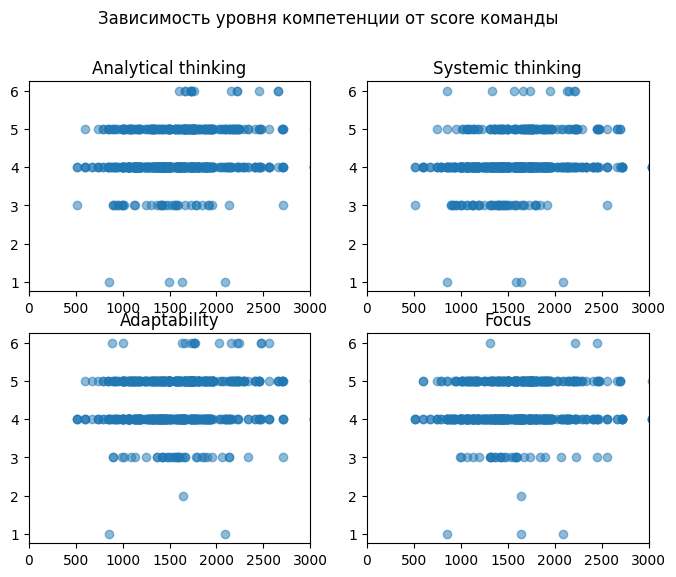

In [2962]:
fig, axes = plt.subplots(nrows = 2, ncols =2 )

fig .set_size_inches(8, 6)

name_score = df_score.drop(col_drop, axis = 1).columns.unique()

for k in range(len(name_score)):
    i = np.floor(k/2)
    i = i.astype(int)
    j = k - i*2
    j = j.astype(int)
        
    axes[i,j].set(title=name_score[k])
       
    axes[i,j].set_xlim(0,3000) #сделаем одну шкалу
   
    axes[i,j].set_yticks([1, 2, 3, 4, 5, 6])
    axes[i,j].scatter(x=df_score['total_score'], y = df_score[name_score[k]], alpha=0.5)
    
plt.suptitle('Зависимость уровня компетенции от score команды', x=0.5, y=1)
plt.show()

Преобразуем score  в места

In [2963]:
df_score = df.set_index('id').join(user_score, how = 'left')

In [2964]:
df_score.head()

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
id,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,1188,-5.00,-25.00,391.00,128.00,105.00,594.00,0.55,-0.04,-0.13,0.77,0.74,1.00,0.55
10106,5.00,4.00,5.00,5.00,211,1828,54.00,120.00,467.00,160.00,113.00,914.00,1.00,1.00,0.90,0.99,0.90,1.00,1.00
10438,6.00,5.00,5.00,5.00,242,1604,55.00,60.00,383.00,158.00,146.00,802.00,1.00,1.00,0.69,0.98,1.00,0.81,1.00
10130,5.00,4.00,5.00,5.00,184,1334,31.00,24.00,366.00,139.00,107.00,667.00,0.62,0.30,0.12,0.71,0.69,1.00,0.62
10667,4.00,5.00,5.00,5.00,193,1756,71.00,70.00,416.00,166.00,155.00,878.00,0.72,0.41,0.26,0.97,0.80,0.87,0.72


In [2965]:
df_score.drop(['game_id'], axis=1).corr()

,Analytical thinking,Systemic thinking,Adaptability,Focus,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
Analytical thinking,1.00,0.56,0.55,0.54,0.16,0.15,0.18,0.10,0.16,-0.04,0.16,0.16,0.02,0.09,0.08,0.16,-0.01,0.16
Systemic thinking,0.56,1.00,0.48,0.49,0.19,0.17,0.20,0.12,0.19,-0.05,0.19,0.16,0.05,0.07,0.08,0.15,0.02,0.16
Adaptability,0.55,0.48,1.00,0.59,0.11,0.11,0.13,0.05,0.11,-0.00,0.11,0.11,-0.01,0.09,-0.01,0.13,0.06,0.11
Focus,0.54,0.49,0.59,1.00,0.08,0.07,0.09,0.06,0.08,-0.01,0.08,0.11,0.04,0.03,0.06,0.12,0.06,0.11
total_score,0.16,0.19,0.11,0.08,1.00,0.96,0.97,0.75,0.92,0.02,1.00,0.77,0.27,0.30,0.53,0.67,0.19,0.77
cat_1,0.15,0.17,0.11,0.07,0.96,1.00,0.93,0.65,0.86,0.06,0.96,0.70,0.25,0.28,0.45,0.58,0.20,0.70
cat_2,0.18,0.20,0.13,0.09,0.97,0.93,1.00,0.64,0.89,-0.04,0.97,0.78,0.29,0.31,0.44,0.67,0.15,0.78
cat_3,0.10,0.12,0.05,0.06,0.75,0.65,0.64,1.00,0.61,-0.40,0.75,0.56,0.21,0.18,0.71,0.42,-0.17,0.56
cat_4,0.16,0.19,0.11,0.08,0.92,0.86,0.89,0.61,1.00,0.03,0.92,0.70,0.24,0.27,0.40,0.74,0.22,0.70
cat_5,-0.04,-0.05,-0.00,-0.01,0.02,0.06,-0.04,-0.40,0.03,1.00,0.02,0.04,-0.06,0.03,-0.17,0.07,0.66,0.04


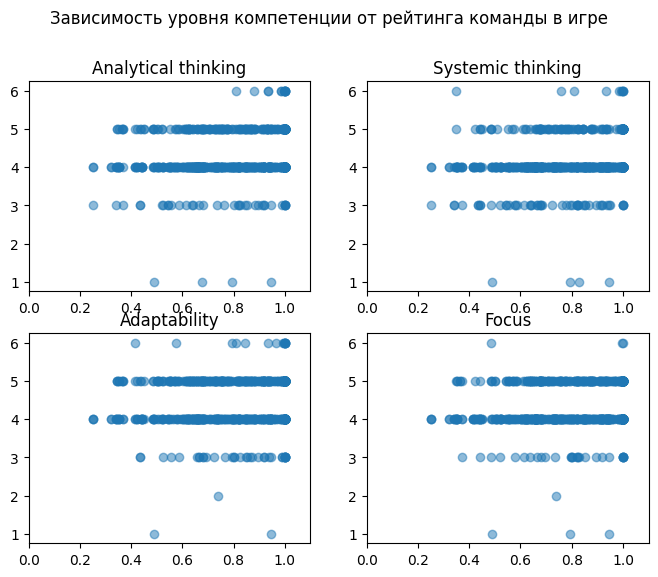

In [2966]:
fig, axes = plt.subplots(nrows = 2, ncols =2 )

fig .set_size_inches(8, 6)

name_score = df_score.drop(col_drop, axis = 1).columns.unique()

for k in range(len(name_score)):
    i = np.floor(k/2)
    i = i.astype(int)
    j = k - i*2
    j = j.astype(int)
        
    axes[i,j].set(title=name_score[k])
       
    axes[i,j].set_xlim(0,1.1) #сделаем одну шкалу
   
    axes[i,j].set_yticks([1, 2, 3, 4, 5, 6])
    axes[i,j].scatter(x=df_score['score_rating'], y = df_score[name_score[k]], alpha=0.5)
    
plt.suptitle('Зависимость уровня компетенции от рейтинга команды в игре', x=0.5, y=1)
plt.show()

**Распределение таргета**

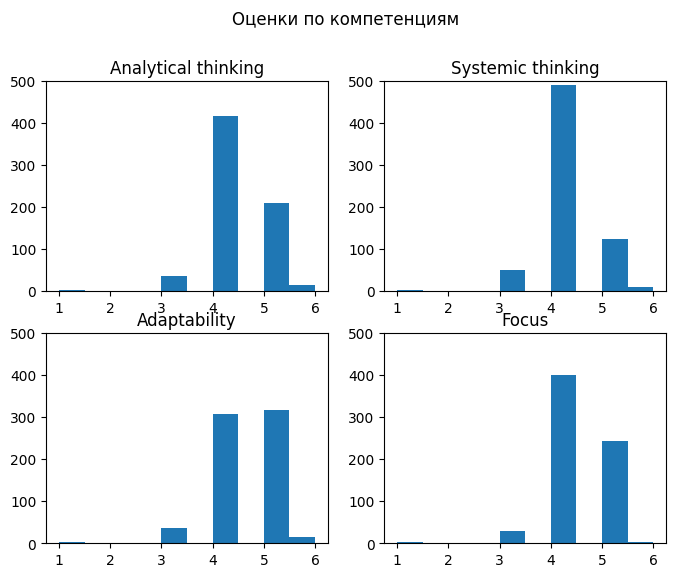

In [2967]:
fig, axes = plt.subplots(nrows = 2, ncols =2 )

fig .set_size_inches(8, 6)

name_score = df.drop('id', axis = 1).columns.unique()

for k in range(len(name_score)):
    i = np.floor(k/2)
    i = i.astype(int)
    j = k - i*2
    j = j.astype(int)
        
    axes[i,j].set(title=name_score[k])
       
    axes[i,j].set_ylim(0,500) #сделаем одну шкалу
   
    axes[i,j].set_xticks([1, 2, 3, 4, 5, 6])
    axes[i,j].hist(df[name_score[k]])
    
plt.suptitle('Оценки по компетенциям', x=0.5, y=1)
plt.show()

## Модель OHE-решений

In [2968]:
user_decision['decision_id'].describe()

count   60,228.00
mean       210.20
std        130.66
min          1.00
25%         92.00
50%        181.00
75%        326.00
max        437.00
Name: decision_id, dtype: float64

In [2969]:
user_decision.head()

,user_id,period,decision_id
0,10625,1,409
1,10318,3,203
2,10775,4,420
3,10236,2,284
4,10130,3,72


In [2970]:
ud = user_decision

In [2971]:
ud = ud.set_index('decision_id').join(decision.set_index('decision_id'), on = 'decision_id', how = 'left').reset_index()

In [2972]:
ud.head()

,decision_id,user_id,period,decision_name
0,409,10625,1,Sending Engineers on training courses
1,203,10318,3,"Sell overdue 30>d accounts receivable, which a..."
2,420,10775,4,Quality of the purchased materials Packing mat...
3,284,10236,2,Improvement of the technology of entrance control
4,72,10130,3,Education of the dealersвЂ™ sales staff


In [2973]:
ud.shape

(60228, 4)

In [2974]:
for col in range(1, 439):
    col_name = str(col)
    ud[col_name] = col
    

In [2975]:
def ohe(col_name):
    if col_name == number_decision:
        return 1
    else:
        return 0

In [2976]:
for col in range(1, 439):
    col_name = str(col)
    number_decision = col
    ud[col_name] = ud['decision_id'].apply(ohe)

In [2977]:
ud.isna().sum()

decision_id      0
user_id          0
period           0
decision_name    0
1                0
                ..
434              0
435              0
436              0
437              0
438              0
Length: 442, dtype: int64

In [2978]:
ud.shape

(60228, 442)

In [2979]:
ud.tail()

,decision_id,user_id,period,decision_name,1,2,3,4,5,6,...,429,430,431,432,433,434,435,436,437,438
60223,329,10312,3,Increase in energy efficiency of equipment,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60224,33,10189,1,[Ltd вЂњAdvrt AgencyвЂќ] Audit of companyвЂ™s ...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60225,123,10346,3,Hiring engineers among university graduates,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60226,140,10424,2,Bonuses for innovation and rationalization of ...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60227,405,10050,3,Managers salary,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2980]:
df_1 = df.set_index('id').join(ud.set_index('user_id'), how = 'left').reset_index()

In [2981]:
df_1.head(3)

,index,Analytical thinking,Systemic thinking,Adaptability,Focus,decision_id,period,decision_name,1,2,...,429,430,431,432,433,434,435,436,437,438
0,10001,4.00,4.00,5.00,4.00,126,4,Engineers qualification,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10001,4.00,4.00,5.00,4.00,175,3,Evaluation of the characteristic Moral qualiti...,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10001,4.00,4.00,5.00,4.00,165,3,Sending staff on short-term courses of time ma...,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2982]:
df_1 = df_1.groupby('index').max()

In [2983]:
df_1 = df_1.drop(['decision_id','period','decision_name'], axis=1)
df_1.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,1,2,3,4,5,6,...,429,430,431,432,433,434,435,436,437,438
index,,,,,,,,,,,,,,,,,,,,,
10001,4.00,4.00,5.00,4.00,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


**Подбор весов для индивидуальных решений**

In [2984]:
df_2 = df_1
df_3 = df_1
df_4 = df_1

**Analytical thinking**

In [2985]:
list_dec_1 = []
for i in range(1, 438):
    cor = df_1['Analytical thinking'].corr(df_1[str(i)]) ** 2
    list_dec_1.append({'i': i, 
                   'corr' : cor})
list_dec_1 = pd.DataFrame(list_dec_1).set_index('i')
list_dec_1['corr'] = list_dec_1['corr'].fillna(0)

In [2986]:
for i in range(1, 438):
    if i in list_dec_1.index:
        corr = list_dec_1['corr'].loc[i]
        df_1[str(i)] = df_1[str(i)] * corr  
    else:
        continue    

**Systemic thinking**

In [2987]:
list_dec_2 = []
for i in range(1, 438):
    cor = df_2['Systemic thinking'].corr(df_2[str(i)]) ** 2
    list_dec_2.append({'i': i, 
                   'corr' : cor})
list_dec_2 = pd.DataFrame(list_dec_2).set_index('i')
list_dec_2['corr'] = list_dec_2['corr'].fillna(0)

In [2988]:
for i in range(1, 438):
    if i in list_dec_2.index:
        corr = list_dec_2['corr'].loc[i]
        df_2[str(i)] = df_2[str(i)] * corr  
    else:
        continue    

**Adaptability**

In [2989]:
list_dec_3 = []
for i in range(1, 438):
    cor = df_3['Adaptability'].corr(df_3[str(i)]) ** 2
    list_dec_3.append({'i': i, 
                   'corr' : cor})
list_dec_3 = pd.DataFrame(list_dec_3).set_index('i')
list_dec_3['corr'] = list_dec_3['corr'].fillna(0)

In [2990]:
for i in range(1, 438):
    if i in list_dec_3.index:
        corr = list_dec_3['corr'].loc[i]
        df_3[str(i)] = df_3[str(i)] * corr  
    else:
        continue    

**Focus**

In [2991]:
list_dec_4 = []
for i in range(1, 438):
    cor = df_4['Focus'].corr(df_4[str(i)]) ** 2
    list_dec_4.append({'i': i, 
                   'corr' : cor})
list_dec_4 = pd.DataFrame(list_dec_4).set_index('i')
list_dec_4['corr'] = list_dec_4['corr'].fillna(0)

In [2992]:
for i in range(1, 438):
    if i in list_dec_4.index:
        corr = list_dec_4['corr'].loc[i]
        df_4[str(i)] = df_4[str(i)] * corr  
    else:
        continue    

In [2993]:
df_1.head()

,Analytical thinking,Systemic thinking,Adaptability,Focus,1,2,3,4,5,6,...,429,430,431,432,433,434,435,436,437,438
index,,,,,,,,,,,,,,,,,,,,,
10001,4.00,4.00,5.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
10003,5.00,5.00,5.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
10004,4.00,4.00,5.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
10006,4.00,4.00,5.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
10008,5.00,4.00,5.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [2994]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability', 'Focus']

In [2995]:
df_1['total'] = df_1.drop(col_drop, axis=1).sum(axis=1)

In [2996]:
df_1.shape

(680, 443)

## 'Analytical thinking' (в трейне: ОНЕ-решений, баллы и рейтинги)

In [2997]:
df_score.head()

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
id,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,1188,-5.00,-25.00,391.00,128.00,105.00,594.00,0.55,-0.04,-0.13,0.77,0.74,1.00,0.55
10106,5.00,4.00,5.00,5.00,211,1828,54.00,120.00,467.00,160.00,113.00,914.00,1.00,1.00,0.90,0.99,0.90,1.00,1.00
10438,6.00,5.00,5.00,5.00,242,1604,55.00,60.00,383.00,158.00,146.00,802.00,1.00,1.00,0.69,0.98,1.00,0.81,1.00
10130,5.00,4.00,5.00,5.00,184,1334,31.00,24.00,366.00,139.00,107.00,667.00,0.62,0.30,0.12,0.71,0.69,1.00,0.62
10667,4.00,5.00,5.00,5.00,193,1756,71.00,70.00,416.00,166.00,155.00,878.00,0.72,0.41,0.26,0.97,0.80,0.87,0.72


In [2998]:
df_1.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,1,2,3,4,5,6,...,430,431,432,433,434,435,436,437,438,total
index,,,,,,,,,,,,,,,,,,,,,
10001,4.00,4.00,5.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00


In [2999]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability','Focus']

In [3000]:
df_7 = df_score.join(df_1.drop(col_drop, axis=1))

In [3001]:
df_7.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,430,431,432,433,434,435,436,437,438,total
id,,,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,1188,-5.00,-25.00,391.00,128.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00


In [3002]:
df_7['max_total'] = df_7.groupby('game_id')['total'].transform('max')

In [3003]:
df_7['rating_user'] = df_7['total'] / df_7['max_total']

In [3004]:
df_7 = df_7[df_7['Analytical thinking']>2]
df_7 = df_7[df_7['Systemic thinking']>2]
df_7 = df_7[df_7['Adaptability']>2]
df_7 = df_7[df_7['Focus']>2]
df_7.shape

(674, 460)

In [3005]:
for i in range(1, 439):
    df_7 = df_7.drop(str(i), axis=1)    

In [3006]:
df_7.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,max_total,rating_user
id,,,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,1188,-5.00,-25.00,391.00,128.00,...,0.55,-0.04,-0.13,0.77,0.74,1.00,0.55,0.00,0.00,0.39


In [3007]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability', 
            'Focus', 'max_total']

In [3008]:
X_train, X_test, y_train, y_test = train_test_split(
    df_7.drop(col_drop, axis=1), df_7['Analytical thinking'], stratify = df_7['Analytical thinking'], test_size=0.25, random_state=12345)

In [3009]:
print(X_train.shape)
print(y_train.shape)

(505, 17)
(505,)


In [3010]:
X_train.head()

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,
10732,252,2090,86.00,174.00,487.00,197.00,101.00,"1,045.00",0.95,0.80,0.73,1.00,0.99,1.00,0.95,0.00,0.03
10804,244,2130,114.00,253.00,337.00,201.00,160.00,"1,065.00",1.00,1.00,1.00,0.75,1.00,1.00,1.00,0.00,0.74
10508,252,1492,39.00,51.00,440.00,129.00,87.00,746.00,0.68,0.36,0.21,0.90,0.65,0.86,0.68,0.00,0.97
10219,244,1282,-3.00,15.00,353.00,149.00,127.00,641.00,0.60,-0.03,0.06,0.78,0.74,0.79,0.60,0.00,0.02
10426,182,1188,-9.00,-21.00,443.00,124.00,57.00,594.00,0.44,-0.05,-0.07,0.88,0.53,0.43,0.44,0.00,0.75


In [3011]:
scaler_1 = StandardScaler()
scaler_1.fit(X_train)
X_train = scaler_1.transform(X_train)
X_test = scaler_1.transform(X_test)

**LogReg**

In [3012]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [3013]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [3014]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

0.293474149320498

In [3015]:
scores = cross_val_score(model, X_train, y_train, cv=5)
scores

array([0.6039604 , 0.52475248, 0.69306931, 0.61386139, 0.62376238])

In [3016]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.28979591836734697

In [3017]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.3004807692307693

In [3018]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         9
         4.0       0.66      0.89      0.76       104
         5.0       0.57      0.31      0.40        52
         6.0       0.00      0.00      0.00         4

    accuracy                           0.64       169
   macro avg       0.31      0.30      0.29       169
weighted avg       0.58      0.64      0.59       169



In [3019]:
total_score_1 = []
total_score_1.append({      'model': 'log_reg',
                           'recall': r_s})
pd.DataFrame(total_score_1)

,model,recall
0,log_reg,0.30


**RFC**

In [3020]:
clf = RandomForestClassifier(random_state=12345)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=12345)

In [3021]:
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

In [3022]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

1.0

In [3023]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([0.54455446, 0.58415842, 0.66336634, 0.65346535, 0.62376238])

In [3024]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.3580131084273215

In [3025]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.35122863247863245

In [3026]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.33      0.22      0.27         9
         4.0       0.67      0.84      0.75       104
         5.0       0.53      0.35      0.42        52
         6.0       0.00      0.00      0.00         4

    accuracy                           0.63       169
   macro avg       0.38      0.35      0.36       169
weighted avg       0.60      0.63      0.60       169



In [3027]:
total_score_1.append({
                           'model': 'RFC',
                           'recall': r_s})
pd.DataFrame(total_score_1)

,model,recall
0,log_reg,0.30
1,RFC,0.35


**LGBM**

In [3028]:
lgbm = LGBMClassifier()

In [3029]:
parameters_lgbm = {'max_depth': [3, 6, 12],
                  'learning_rate':[0.005, 0.01, 0.03]}

In [3030]:
lgbm = GridSearchCV(lgbm, parameters_lgbm)

In [3031]:
%%time
lgbm.fit(X_train, y_train)

CPU times: total: 20.7 s
Wall time: 2.68 s


GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.005, 0.01, 0.03],
                         'max_depth': [3, 6, 12]})

In [3032]:
lgbm.best_params_

{'learning_rate': 0.005, 'max_depth': 3}

In [3033]:
pred_train = lgbm.predict(X_train)
pred_test = lgbm.predict(X_test)

In [3034]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

0.25952519702519705

In [3035]:
scores = cross_val_score(lgbm, X_train, y_train, cv=5)
scores

array([0.58415842, 0.55445545, 0.6039604 , 0.59405941, 0.59405941])

In [3036]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.2078423671118094

In [3037]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.2548076923076923

In [3038]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         9
         4.0       0.62      0.98      0.76       104
         5.0       0.40      0.04      0.07        52
         6.0       0.00      0.00      0.00         4

    accuracy                           0.62       169
   macro avg       0.26      0.25      0.21       169
weighted avg       0.51      0.62      0.49       169



In [3039]:
total_score_1.append({
                           'model': 'LGBM',
                           'recall': r_s})
pd.DataFrame(total_score_1)

,model,recall
0,log_reg,0.30
1,RFC,0.35
2,LGBM,0.25


In [3040]:
X_train = df_7.drop(col_drop, axis=1) 
y_train = df_7['Analytical thinking']
lgbm.fit(X_train, y_train)
model_1 = lgbm

## 'Systemic thinking' (в трейне: ОНЕ-решений, баллы и рейтинги)

In [3041]:
df_score.head()

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
id,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,1188,-5.00,-25.00,391.00,128.00,105.00,594.00,0.55,-0.04,-0.13,0.77,0.74,1.00,0.55
10106,5.00,4.00,5.00,5.00,211,1828,54.00,120.00,467.00,160.00,113.00,914.00,1.00,1.00,0.90,0.99,0.90,1.00,1.00
10438,6.00,5.00,5.00,5.00,242,1604,55.00,60.00,383.00,158.00,146.00,802.00,1.00,1.00,0.69,0.98,1.00,0.81,1.00
10130,5.00,4.00,5.00,5.00,184,1334,31.00,24.00,366.00,139.00,107.00,667.00,0.62,0.30,0.12,0.71,0.69,1.00,0.62
10667,4.00,5.00,5.00,5.00,193,1756,71.00,70.00,416.00,166.00,155.00,878.00,0.72,0.41,0.26,0.97,0.80,0.87,0.72


In [3042]:
df_2.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,1,2,3,4,5,6,...,430,431,432,433,434,435,436,437,438,total
index,,,,,,,,,,,,,,,,,,,,,
10001,4.00,4.00,5.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00


In [3043]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability','Focus']

In [3044]:
df_7 = df_score.join(df_2.drop(col_drop, axis=1))

In [3045]:
df_7.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,430,431,432,433,434,435,436,437,438,total
id,,,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,1188,-5.00,-25.00,391.00,128.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00


In [3046]:
df_7['max_total'] = df_7.groupby('game_id')['total'].transform('max')

In [3047]:
df_7['rating_user'] = df_7['total'] / df_7['max_total']

In [3048]:
df_7 = df_7[df_7['Analytical thinking']>2]
df_7 = df_7[df_7['Systemic thinking']>2]
df_7 = df_7[df_7['Adaptability']>2]
df_7 = df_7[df_7['Focus']>2]
df_7.shape

(674, 460)

In [3049]:
for i in range(1, 439):
    df_7 = df_7.drop(str(i), axis=1)    

In [3050]:
df_7.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,max_total,rating_user
id,,,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,1188,-5.00,-25.00,391.00,128.00,...,0.55,-0.04,-0.13,0.77,0.74,1.00,0.55,0.00,0.00,0.39


In [3051]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability', 
            'Focus', 'max_total']

In [3052]:
X_train, X_test, y_train, y_test = train_test_split(
    df_7.drop(col_drop, axis=1), df_7['Systemic thinking'], stratify = df_7['Systemic thinking'], test_size=0.25, random_state=12345)

In [3053]:
print(X_train.shape)
print(y_train.shape)

(505, 17)
(505,)


In [3054]:
X_train.head()

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,
10561,247,1004,-21.00,-14.00,312.00,112.00,113.00,502.00,0.37,-0.11,-0.05,0.59,0.48,0.93,0.37,0.00,0.04
10222,235,1498,25.00,80.00,440.00,139.00,65.00,749.00,0.87,0.61,0.62,0.87,0.90,0.62,0.87,0.00,0.25
10234,234,1640,48.00,119.00,367.00,144.00,142.00,820.00,0.93,0.83,0.73,0.94,0.97,0.85,0.93,0.00,0.02
10182,239,1658,34.00,129.00,357.00,153.00,156.00,829.00,1.00,0.79,1.00,0.86,1.00,1.00,1.00,0.00,0.03
10699,184,1866,58.00,157.00,413.00,200.00,105.00,933.00,0.87,0.57,0.79,0.81,1.00,0.98,0.87,0.00,0.68


In [3055]:
scaler_2 = StandardScaler()
scaler_2.fit(X_train)
X_train = scaler_2.transform(X_train)
X_test = scaler_2.transform(X_test)

**LogReg**

In [3056]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [3057]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [3058]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

0.24991403632516312

In [3059]:
scores = cross_val_score(model, X_train, y_train, cv=5)
scores

array([0.74257426, 0.65346535, 0.71287129, 0.69306931, 0.71287129])

In [3060]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.2670940170940171

In [3061]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.27819302386572253

In [3062]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00        13
         4.0       0.74      0.98      0.85       123
         5.0       0.80      0.13      0.22        31
         6.0       0.00      0.00      0.00         2

    accuracy                           0.74       169
   macro avg       0.39      0.28      0.27       169
weighted avg       0.69      0.74      0.66       169



In [3063]:
total_score_2 = []
total_score_2.append({      'model': 'log_reg',
                           'recall': r_s})
pd.DataFrame(total_score_2)

,model,recall
0,log_reg,0.28


**RFC**

In [3064]:
clf = RandomForestClassifier(random_state=12345)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=12345)

In [3065]:
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

In [3066]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

1.0

In [3067]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([0.63366337, 0.66336634, 0.65346535, 0.63366337, 0.7029703 ])

In [3068]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.30750164690382087

In [3069]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.30406604934535697

In [3070]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.22      0.15      0.18        13
         4.0       0.78      0.74      0.76       123
         5.0       0.26      0.32      0.29        31
         6.0       0.00      0.00      0.00         2

    accuracy                           0.61       169
   macro avg       0.32      0.30      0.31       169
weighted avg       0.63      0.61      0.62       169



In [3071]:
total_score_2.append({
                           'model': 'RFC',
                           'recall': r_s})
pd.DataFrame(total_score_2)

,model,recall
0,log_reg,0.28
1,RFC,0.30


**LGBM**

In [3072]:
lgbm = LGBMClassifier()

In [3073]:
parameters_lgbm = {'max_depth': [3, 6, 12],
                  'learning_rate':[0.001, 0.003, 0.005, 0.01]}

In [3074]:
lgbm = GridSearchCV(lgbm, parameters_lgbm)

In [3075]:
%%time
lgbm.fit(X_train, y_train)

CPU times: total: 26.9 s
Wall time: 3.55 s


GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.001, 0.003, 0.005, 0.01],
                         'max_depth': [3, 6, 12]})

In [3076]:
lgbm.best_params_

{'learning_rate': 0.001, 'max_depth': 3}

In [3077]:
pred_train = lgbm.predict(X_train)
pred_test = lgbm.predict(X_test)

In [3078]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

0.21010332950631458

In [3079]:
scores = cross_val_score(lgbm, X_train, y_train, cv=5)
scores

array([0.73267327, 0.72277228, 0.72277228, 0.72277228, 0.72277228])

In [3080]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.2106164383561644

In [3081]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.25

In [3082]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00        13
         4.0       0.73      1.00      0.84       123
         5.0       0.00      0.00      0.00        31
         6.0       0.00      0.00      0.00         2

    accuracy                           0.73       169
   macro avg       0.18      0.25      0.21       169
weighted avg       0.53      0.73      0.61       169



In [3083]:
total_score_2.append({
                           'model': 'LGBM',
                           'recall': r_s})
pd.DataFrame(total_score_2)

,model,recall
0,log_reg,0.28
1,RFC,0.30
2,LGBM,0.25


In [3084]:
X_train = df_7.drop(col_drop, axis=1) 
y_train = df_7['Systemic thinking']
lgbm.fit(X_train, y_train)
model_2 = lgbm

## 'Adaptability' (в трейне: ОНЕ-решений, баллы и рейтинги)

In [3085]:
df_score.head()

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
id,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,1188,-5.00,-25.00,391.00,128.00,105.00,594.00,0.55,-0.04,-0.13,0.77,0.74,1.00,0.55
10106,5.00,4.00,5.00,5.00,211,1828,54.00,120.00,467.00,160.00,113.00,914.00,1.00,1.00,0.90,0.99,0.90,1.00,1.00
10438,6.00,5.00,5.00,5.00,242,1604,55.00,60.00,383.00,158.00,146.00,802.00,1.00,1.00,0.69,0.98,1.00,0.81,1.00
10130,5.00,4.00,5.00,5.00,184,1334,31.00,24.00,366.00,139.00,107.00,667.00,0.62,0.30,0.12,0.71,0.69,1.00,0.62
10667,4.00,5.00,5.00,5.00,193,1756,71.00,70.00,416.00,166.00,155.00,878.00,0.72,0.41,0.26,0.97,0.80,0.87,0.72


In [3086]:
df_3.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,1,2,3,4,5,6,...,430,431,432,433,434,435,436,437,438,total
index,,,,,,,,,,,,,,,,,,,,,
10001,4.00,4.00,5.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00


In [3087]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability','Focus']

In [3088]:
df_7 = df_score.join(df_3.drop(col_drop, axis=1))

In [3089]:
df_7.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,430,431,432,433,434,435,436,437,438,total
id,,,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,1188,-5.00,-25.00,391.00,128.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00


In [3090]:
df_7['max_total'] = df_7.groupby('game_id')['total'].transform('max')

In [3091]:
df_7['rating_user'] = df_7['total'] / df_7['max_total']

In [3092]:
df_7 = df_7[df_7['Analytical thinking']>2]
df_7 = df_7[df_7['Systemic thinking']>2]
df_7 = df_7[df_7['Adaptability']>2]
df_7 = df_7[df_7['Focus']>2]
df_7.shape

(674, 460)

In [3093]:
for i in range(1, 439):
    df_7 = df_7.drop(str(i), axis=1)    

In [3094]:
df_7.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,max_total,rating_user
id,,,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,1188,-5.00,-25.00,391.00,128.00,...,0.55,-0.04,-0.13,0.77,0.74,1.00,0.55,0.00,0.00,0.39


In [3095]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability', 
            'Focus', 'max_total']

In [3096]:
X_train, X_test, y_train, y_test = train_test_split(
    df_7.drop(col_drop, axis=1), df_7['Adaptability'], stratify = df_7['Adaptability'], test_size=0.25, random_state=12345)

In [3097]:
print(X_train.shape)
print(y_train.shape)

(505, 17)
(505,)


In [3098]:
X_train.head()

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,
10954,262,1130,-9.00,-17.00,368.00,140.00,83.00,565.00,0.72,-0.30,-0.13,0.84,0.79,0.74,0.72,0.00,0.84
10721,192,1224,10.00,22.00,379.00,129.00,72.00,612.00,0.51,0.05,0.15,0.72,0.70,0.43,0.51,0.00,0.36
10220,235,1498,25.00,80.00,440.00,139.00,65.00,749.00,0.87,0.61,0.62,0.87,0.90,0.62,0.87,0.00,0.18
10171,252,1586,35.00,133.00,344.00,183.00,98.00,793.00,0.72,0.33,0.56,0.71,0.92,0.97,0.72,0.00,0.04
10126,209,1898,89.00,119.00,468.00,165.00,108.00,949.00,1.00,1.00,0.79,1.00,0.87,0.71,1.00,0.00,0.07


In [3099]:
scaler_3 = StandardScaler()
scaler_3.fit(X_train)
X_train = scaler_3.transform(X_train)
X_test = scaler_3.transform(X_test)

**LogReg**

In [3100]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [3101]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [3102]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

0.30828009599621425

In [3103]:
scores = cross_val_score(model, X_train, y_train, cv=5)
scores

array([0.59405941, 0.52475248, 0.53465347, 0.4950495 , 0.56435644])

In [3104]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.3098644578313253

In [3105]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.3218344155844156

In [3106]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         8
         4.0       0.57      0.66      0.61        77
         5.0       0.62      0.62      0.62        80
         6.0       0.00      0.00      0.00         4

    accuracy                           0.60       169
   macro avg       0.30      0.32      0.31       169
weighted avg       0.56      0.60      0.58       169



In [3107]:
total_score_3 = []
total_score_3.append({      'model': 'log_reg',
                           'recall': r_s})
pd.DataFrame(total_score_3)

,model,recall
0,log_reg,0.32


**RFC**

In [3108]:
clf = RandomForestClassifier(random_state=12345)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=12345)

In [3109]:
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

In [3110]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

1.0

In [3111]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([0.56435644, 0.5049505 , 0.53465347, 0.56435644, 0.4950495 ])

In [3112]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.3148268109591129

In [3113]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.32495941558441555

In [3114]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         8
         4.0       0.59      0.66      0.63        77
         5.0       0.63      0.64      0.63        80
         6.0       0.00      0.00      0.00         4

    accuracy                           0.60       169
   macro avg       0.31      0.32      0.31       169
weighted avg       0.57      0.60      0.59       169



In [3115]:
total_score_3.append({
                           'model': 'RFC',
                           'recall': r_s})
pd.DataFrame(total_score_3)

,model,recall
0,log_reg,0.32
1,RFC,0.32


**LGBM**

In [3116]:
lgbm = LGBMClassifier()

In [3117]:
parameters_lgbm = {'max_depth': [3, 6, 12],
                  'learning_rate':[0.01, 0.03, 0.1]}

In [3118]:
lgbm = GridSearchCV(lgbm, parameters_lgbm)

In [3119]:
%%time
lgbm.fit(X_train, y_train)

CPU times: total: 20.6 s
Wall time: 2.72 s


GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.01, 0.03, 0.1],
                         'max_depth': [3, 6, 12]})

In [3120]:
lgbm.best_params_

{'learning_rate': 0.03, 'max_depth': 6}

In [3121]:
pred_train = lgbm.predict(X_train)
pred_test = lgbm.predict(X_test)

In [3122]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

0.8472953859693236

In [3123]:
scores = cross_val_score(lgbm, X_train, y_train, cv=5)
scores

array([0.57425743, 0.57425743, 0.46534653, 0.4950495 , 0.53465347])

In [3124]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.3354166666666667

In [3125]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.34732142857142856

In [3126]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         8
         4.0       0.62      0.71      0.67        77
         5.0       0.68      0.68      0.68        80
         6.0       0.00      0.00      0.00         4

    accuracy                           0.64       169
   macro avg       0.33      0.35      0.34       169
weighted avg       0.60      0.64      0.62       169



In [3127]:
total_score_3.append({
                           'model': 'LGBM',
                           'recall': r_s})
pd.DataFrame(total_score_3)

,model,recall
0,log_reg,0.32
1,RFC,0.32
2,LGBM,0.35


In [3128]:
X_train = df_7.drop(col_drop, axis=1) 
y_train = df_7['Adaptability']
lgbm.fit(X_train, y_train)
model_3 = lgbm

## 'Focus' (в трейне: ОНЕ-решений, баллы и рейтинги)

In [3129]:
df_score.head()

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
id,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,1188,-5.00,-25.00,391.00,128.00,105.00,594.00,0.55,-0.04,-0.13,0.77,0.74,1.00,0.55
10106,5.00,4.00,5.00,5.00,211,1828,54.00,120.00,467.00,160.00,113.00,914.00,1.00,1.00,0.90,0.99,0.90,1.00,1.00
10438,6.00,5.00,5.00,5.00,242,1604,55.00,60.00,383.00,158.00,146.00,802.00,1.00,1.00,0.69,0.98,1.00,0.81,1.00
10130,5.00,4.00,5.00,5.00,184,1334,31.00,24.00,366.00,139.00,107.00,667.00,0.62,0.30,0.12,0.71,0.69,1.00,0.62
10667,4.00,5.00,5.00,5.00,193,1756,71.00,70.00,416.00,166.00,155.00,878.00,0.72,0.41,0.26,0.97,0.80,0.87,0.72


In [3130]:
df_4.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,1,2,3,4,5,6,...,430,431,432,433,434,435,436,437,438,total
index,,,,,,,,,,,,,,,,,,,,,
10001,4.00,4.00,5.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00


In [3131]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability','Focus']

In [3132]:
df_7 = df_score.join(df_4.drop(col_drop, axis=1))

In [3133]:
df_7.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,430,431,432,433,434,435,436,437,438,total
id,,,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,1188,-5.00,-25.00,391.00,128.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00


In [3134]:
df_7['max_total'] = df_7.groupby('game_id')['total'].transform('max')

In [3135]:
df_7['rating_user'] = df_7['total'] / df_7['max_total']

In [3136]:
df_7 = df_7[df_7['Analytical thinking']>2]
df_7 = df_7[df_7['Systemic thinking']>2]
df_7 = df_7[df_7['Adaptability']>2]
df_7 = df_7[df_7['Focus']>2]
df_7.shape

(674, 460)

In [3137]:
for i in range(1, 439):
    df_7 = df_7.drop(str(i), axis=1)    

In [3138]:
df_7.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,max_total,rating_user
id,,,,,,,,,,,,,,,,,,,,,
10884,4.00,4.00,4.00,4.00,202,1188,-5.00,-25.00,391.00,128.00,...,0.55,-0.04,-0.13,0.77,0.74,1.00,0.55,0.00,0.00,0.39


In [3139]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability', 
            'Focus', 'max_total']

In [3140]:
X_train, X_test, y_train, y_test = train_test_split(
    df_7.drop(col_drop, axis=1), df_7['Focus'], stratify = df_7['Focus'], test_size=0.25, random_state=12345)

In [3141]:
print(X_train.shape)
print(y_train.shape)

(505, 17)
(505,)


In [3142]:
X_train.head()

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,
10390,236,2334,132.00,224.00,535.00,188.00,88.00,"1,167.00",0.77,0.56,0.61,1.00,0.67,0.86,0.77,0.00,0.00
10694,238,1918,71.00,115.00,495.00,173.00,105.00,959.00,0.91,0.71,0.53,1.00,0.95,0.80,0.91,0.00,0.75
10811,237,1666,52.00,89.00,392.00,165.00,135.00,833.00,0.93,0.65,0.53,0.94,0.88,0.98,0.93,0.00,0.02
10140,233,2022,93.00,182.00,446.00,191.00,99.00,"1,011.00",1.00,1.00,1.00,1.00,1.00,0.98,1.00,0.00,1.00
10903,243,1180,-21.00,9.00,373.00,118.00,111.00,590.00,0.69,-0.64,0.07,0.78,0.73,0.97,0.69,0.00,0.07


In [3143]:
scaler_4 = StandardScaler()
scaler_4.fit(X_train)
X_train = scaler_4.transform(X_train)
X_test = scaler_4.transform(X_test)

**LogReg**

In [3144]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [3145]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [3146]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

0.3177946451386983

In [3147]:
scores = cross_val_score(model, X_train, y_train, cv=5)
scores

array([0.6039604 , 0.59405941, 0.68316832, 0.61386139, 0.62376238])

In [3148]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.2745349433540025

In [3149]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.28807377049180327

In [3150]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         7
         4.0       0.63      0.89      0.74       100
         5.0       0.57      0.26      0.36        61
         6.0       0.00      0.00      0.00         1

    accuracy                           0.62       169
   macro avg       0.30      0.29      0.27       169
weighted avg       0.58      0.62      0.57       169



In [3151]:
total_score_4 = []
total_score_4.append({      'model': 'log_reg',
                           'recall': r_s})
pd.DataFrame(total_score_4)

,model,recall
0,log_reg,0.29


**RFC**

In [3152]:
clf = RandomForestClassifier(random_state=12345)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=12345)

In [3153]:
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

In [3154]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

1.0

In [3155]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([0.54455446, 0.56435644, 0.58415842, 0.56435644, 0.54455446])

In [3156]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.2941610272427555

In [3157]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.2992622950819672

In [3158]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         7
         4.0       0.65      0.82      0.73       100
         5.0       0.56      0.38      0.45        61
         6.0       0.00      0.00      0.00         1

    accuracy                           0.62       169
   macro avg       0.30      0.30      0.29       169
weighted avg       0.59      0.62      0.59       169



In [3159]:
total_score_4.append({
                           'model': 'RFC',
                           'recall': r_s})
pd.DataFrame(total_score_4)

,model,recall
0,log_reg,0.29
1,RFC,0.30


**LGBM**

In [3160]:
lgbm = LGBMClassifier()

In [3161]:
parameters_lgbm = {'max_depth': [3, 6, 12],
                  'learning_rate':[0.01, 0.03, 0.1]}

In [3162]:
lgbm = GridSearchCV(lgbm, parameters_lgbm)

In [3163]:
%%time
lgbm.fit(X_train, y_train)

CPU times: total: 19.4 s
Wall time: 2.55 s


GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.01, 0.03, 0.1],
                         'max_depth': [3, 6, 12]})

In [3164]:
lgbm.best_params_

{'learning_rate': 0.03, 'max_depth': 3}

In [3165]:
pred_train = lgbm.predict(X_train)
pred_test = lgbm.predict(X_test)

In [3166]:
f1_score(y_train, pred_train, average='macro', zero_division = 0)

0.6787500325984503

In [3167]:
scores = cross_val_score(lgbm, X_train, y_train, cv=5)
scores

array([0.69306931, 0.58415842, 0.6039604 , 0.59405941, 0.63366337])

In [3168]:
f1_score(y_test, pred_test, average='macro', zero_division = 0)

0.2882978723404256

In [3169]:
r_s = recall_score(y_test, pred_test, average = 'macro', zero_division = 0)
r_s

0.2978688524590164

In [3170]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         7
         4.0       0.65      0.88      0.75       100
         5.0       0.58      0.31      0.40        61
         6.0       0.00      0.00      0.00         1

    accuracy                           0.63       169
   macro avg       0.31      0.30      0.29       169
weighted avg       0.59      0.63      0.59       169



In [3171]:
total_score_4.append({
                           'model': 'LGBM',
                           'recall': r_s})
pd.DataFrame(total_score_4)

,model,recall
0,log_reg,0.29
1,RFC,0.30
2,LGBM,0.30


In [3172]:
X_train = df_7.drop(col_drop, axis=1) 
y_train = df_7['Focus']
lgbm.fit(X_train, y_train)
model_4 = lgbm

## Обработка тестовой выборки

In [3173]:
sample_solution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   id                   293 non-null    int64
 1   Analytical thinking  293 non-null    int64
 2   Systemic thinking    293 non-null    int64
 3   Adaptability         293 non-null    int64
 4   Focus                293 non-null    int64
dtypes: int64(5)
memory usage: 11.6 KB


In [3174]:
sample_solution.head()

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,0,0,0,0
1,10539,0,0,0,0
2,10174,0,0,0,0
3,10465,0,0,0,0
4,10066,0,0,0,0


In [3175]:
user_score.head(1)

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
user_id,,,,,,,,,,,,,,,
10273,182,2698,178.00,297.00,506.00,235.00,133.00,"1,349.00",1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [3176]:
df_sample = sample_solution.set_index('id').join(user_score, how = 'left')

In [3177]:
df_sample.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
id,,,,,,,,,,,,,,,,,,,
10199,0,0,0,0,262,1424,11.00,56.00,387.00,151.00,107.00,712.00,0.91,0.37,0.42,0.88,0.85,0.96,0.91


In [3178]:
ud.head(1)

,decision_id,user_id,period,decision_name,1,2,3,4,5,6,...,429,430,431,432,433,434,435,436,437,438
0,409,10625,1,Sending Engineers on training courses,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3179]:
ud.shape

(60228, 442)

In [3180]:
ud = ud.groupby('user_id').max()

In [3181]:
ud = ud.drop(['decision_id', 'period', 'decision_name'], axis=1)

In [3182]:
ud.head(1)

,1,2,3,4,5,6,7,8,9,10,...,429,430,431,432,433,434,435,436,437,438
user_id,,,,,,,,,,,,,,,,,,,,,
10001,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3183]:
ud.shape

(973, 438)

**Analytical thinking**

In [3184]:
ud_1 = ud
ud_2 = ud
ud_3 = ud
ud_4 = ud

In [3185]:
for i in range(1, 438):
    if i in list_dec_1.index:
        corr = list_dec_1['corr'].loc[i]
        ud_1[str(i)] = ud_1[str(i)] * corr  
    else:
        continue    

In [3186]:
ud_1.head(1)

,1,2,3,4,5,6,7,8,9,10,...,429,430,431,432,433,434,435,436,437,438
user_id,,,,,,,,,,,,,,,,,,,,,
10001,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [3187]:
ud_1['total'] = ud_1.sum(axis=1)

In [3188]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability','Focus']

In [3189]:
df_sample_1 = df_sample.join(ud_1)

In [3190]:
df_sample_1.shape

(293, 458)

In [3191]:
df_sample_1.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,430,431,432,433,434,435,436,437,438,total
id,,,,,,,,,,,,,,,,,,,,,
10199,0,0,0,0,262,1424,11.00,56.00,387.00,151.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.06


In [3192]:
df_sample_1['max_total'] = df_sample_1.groupby('game_id')['total'].transform('max')

In [3193]:
df_sample_1['rating_user'] = df_sample_1['total'] / df_sample_1['max_total']

In [3194]:
for i in range(1, 439):
    df_sample_1 = df_sample_1.drop(str(i), axis=1)    

In [3195]:
df_sample_1 = df_sample_1.drop('max_total', axis=1)

In [3196]:
df_sample_1.shape

(293, 21)

In [3197]:
df_sample_1.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,,,,,
10199,0,0,0,0,262,1424,11.00,56.00,387.00,151.00,...,712.00,0.91,0.37,0.42,0.88,0.85,0.96,0.91,0.06,0.05


In [3198]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability', 
            'Focus']

In [3199]:
X_test = df_sample_1.drop(col_drop, axis=1)

In [3200]:
X_test.head(1)

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,
10199,262,1424,11.00,56.00,387.00,151.00,107.00,712.00,0.91,0.37,0.42,0.88,0.85,0.96,0.91,0.06,0.05


In [3201]:
X_test.shape

(293, 17)

In [3202]:
X_test = scaler_1.transform(X_test)

In [3203]:
df_sample['Analytical thinking'] = model_1.predict(X_test).astype('int')

**Systemic thinking**

In [3204]:
for i in range(1, 438):
    if i in list_dec_2.index:
        corr = list_dec_2['corr'].loc[i]
        ud_2[str(i)] = ud_2[str(i)] * corr  
    else:
        continue    

In [3205]:
ud_2.head(1)

,1,2,3,4,5,6,7,8,9,10,...,430,431,432,433,434,435,436,437,438,total
user_id,,,,,,,,,,,,,,,,,,,,,
10001,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.58


In [3206]:
ud_2['total'] = ud_2.sum(axis=1)

In [3207]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability','Focus']

In [3208]:
df_sample_2 = df_sample.join(ud_2)

In [3209]:
df_sample_2.shape

(293, 458)

In [3210]:
df_sample_2.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,430,431,432,433,434,435,436,437,438,total
id,,,,,,,,,,,,,,,,,,,,,
10199,4,0,0,0,262,1424,11.00,56.00,387.00,151.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.06


In [3211]:
df_sample_2['max_total'] = df_sample_2.groupby('game_id')['total'].transform('max')

In [3212]:
df_sample_2['rating_user'] = df_sample_2['total'] / df_sample_2['max_total']

In [3213]:
for i in range(1, 439):
    df_sample_2 = df_sample_2.drop(str(i), axis=1)    

In [3214]:
df_sample_2 = df_sample_2.drop('max_total', axis=1)

In [3215]:
df_sample_2.shape

(293, 21)

In [3216]:
df_sample_2.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,,,,,
10199,4,0,0,0,262,1424,11.00,56.00,387.00,151.00,...,712.00,0.91,0.37,0.42,0.88,0.85,0.96,0.91,0.06,0.05


In [3217]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability', 
            'Focus']

In [3218]:
X_test = df_sample_2.drop(col_drop, axis=1)

In [3219]:
X_test.head(1)

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,
10199,262,1424,11.00,56.00,387.00,151.00,107.00,712.00,0.91,0.37,0.42,0.88,0.85,0.96,0.91,0.06,0.05


In [3220]:
X_test.shape

(293, 17)

In [3221]:
X_test = scaler_2.transform(X_test)

In [3222]:
df_sample['Systemic thinking'] = model_2.predict(X_test).astype('int')

**Adaptability**

In [3223]:
for i in range(1, 438):
    if i in list_dec_3.index:
        corr = list_dec_3['corr'].loc[i]
        ud_3[str(i)] = ud_3[str(i)] * corr  
    else:
        continue    

In [3224]:
ud_3.head(1)

,1,2,3,4,5,6,7,8,9,10,...,430,431,432,433,434,435,436,437,438,total
user_id,,,,,,,,,,,,,,,,,,,,,
10001,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.59


In [3225]:
ud_3['total'] = ud_3.sum(axis=1)

In [3226]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability','Focus']

In [3227]:
df_sample_3 = df_sample.join(ud_3)

In [3228]:
df_sample_3.shape

(293, 458)

In [3229]:
df_sample_3.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,430,431,432,433,434,435,436,437,438,total
id,,,,,,,,,,,,,,,,,,,,,
10199,4,4,0,0,262,1424,11.00,56.00,387.00,151.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.06


In [3230]:
df_sample_3['max_total'] = df_sample_3.groupby('game_id')['total'].transform('max')

In [3231]:
df_sample_3['rating_user'] = df_sample_3['total'] / df_sample_3['max_total']

In [3232]:
for i in range(1, 439):
    df_sample_3 = df_sample_3.drop(str(i), axis=1)    

In [3233]:
df_sample_3 = df_sample_3.drop('max_total', axis=1)

In [3234]:
df_sample_3.shape

(293, 21)

In [3235]:
df_sample_3.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,,,,,
10199,4,4,0,0,262,1424,11.00,56.00,387.00,151.00,...,712.00,0.91,0.37,0.42,0.88,0.85,0.96,0.91,0.06,0.05


In [3236]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability', 
            'Focus']

In [3237]:
X_test = df_sample_3.drop(col_drop, axis=1)

In [3238]:
X_test.head(1)

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,
10199,262,1424,11.00,56.00,387.00,151.00,107.00,712.00,0.91,0.37,0.42,0.88,0.85,0.96,0.91,0.06,0.05


In [3239]:
X_test.shape

(293, 17)

In [3240]:
X_test = scaler_3.transform(X_test)

In [3241]:
df_sample['Adaptability'] = model_3.predict(X_test).astype('int')

**Focus**

In [3242]:
for i in range(1, 438):
    if i in list_dec_4.index:
        corr = list_dec_4['corr'].loc[i]
        ud_4[str(i)] = ud_4[str(i)] * corr  
    else:
        continue    

In [3243]:
ud_4.head(1)

,1,2,3,4,5,6,7,8,9,10,...,430,431,432,433,434,435,436,437,438,total
user_id,,,,,,,,,,,,,,,,,,,,,
10001,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.59


In [3244]:
ud_4['total'] = ud_4.sum(axis=1)

In [3245]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability','Focus']

In [3246]:
df_sample_4 = df_sample.join(ud_4)

In [3247]:
df_sample_4.shape

(293, 458)

In [3248]:
df_sample_4.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,430,431,432,433,434,435,436,437,438,total
id,,,,,,,,,,,,,,,,,,,,,
10199,4,4,4,0,262,1424,11.00,56.00,387.00,151.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.06


In [3249]:
df_sample_4['max_total'] = df_sample_4.groupby('game_id')['total'].transform('max')

In [3250]:
df_sample_4['rating_user'] = df_sample_4['total'] / df_sample_4['max_total']

In [3251]:
for i in range(1, 439):
    df_sample_4 = df_sample_4.drop(str(i), axis=1)    

In [3252]:
df_sample_4 = df_sample_4.drop('max_total', axis=1)

In [3253]:
df_sample_4.shape

(293, 21)

In [3254]:
df_sample_4.head(1)

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,...,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,,,,,
10199,4,4,4,0,262,1424,11.00,56.00,387.00,151.00,...,712.00,0.91,0.37,0.42,0.88,0.85,0.96,0.91,0.06,0.05


In [3255]:
col_drop = ['Analytical thinking', 'Systemic thinking', 'Adaptability', 
            'Focus']

In [3256]:
X_test = df_sample_4.drop(col_drop, axis=1)

In [3257]:
X_test.head(1)

,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,total,rating_user
id,,,,,,,,,,,,,,,,,
10199,262,1424,11.00,56.00,387.00,151.00,107.00,712.00,0.91,0.37,0.42,0.88,0.85,0.96,0.91,0.06,0.05


In [3258]:
X_test.shape

(293, 17)

In [3259]:
X_test = scaler_4.transform(X_test)

In [3260]:
df_sample['Focus'] = model_4.predict(X_test).astype('int')

In [3261]:
df_sample.columns

Index(['Analytical thinking', 'Systemic thinking', 'Adaptability', 'Focus',
       'game_id', 'total_score', 'cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5',
       'cat_6', 'score_rating', 'rating_1', 'rating_2', 'rating_3', 'rating_4',
       'rating_5', 'rating_6'],
      dtype='object')

In [3262]:
col_drop = ['game_id', 'total_score', 'cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5',
       'cat_6', 'score_rating', 'rating_1', 'rating_2', 'rating_3', 'rating_4',
       'rating_5', 'rating_6']

In [3263]:
df_sample.head()

,Analytical thinking,Systemic thinking,Adaptability,Focus,game_id,total_score,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,score_rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6
id,,,,,,,,,,,,,,,,,,,
10199,4,4,4,4,262,1424,11.00,56.00,387.00,151.00,107.00,712.00,0.91,0.37,0.42,0.88,0.85,0.96,0.91
10539,4,4,4,4,204,1168,-18.00,-3.00,356.00,118.00,131.00,584.00,0.67,-0.28,-0.03,0.90,0.69,0.80,0.67
10174,4,4,4,4,190,2268,124.00,206.00,481.00,201.00,122.00,"1,134.00",1.00,1.00,1.00,0.95,1.00,0.95,1.00
10465,5,4,5,5,244,1252,-23.00,-19.00,422.00,132.00,114.00,626.00,0.59,-0.20,-0.08,0.94,0.66,0.71,0.59
10066,4,4,4,4,183,790,-48.00,-80.00,314.00,115.00,94.00,395.00,0.37,-0.51,-0.37,0.59,0.62,0.78,0.37


In [3264]:
df_sample = df_sample.drop(col_drop, axis=1)

In [3265]:
sample_solution = sample_solution.drop(['Analytical thinking', 'Systemic thinking', 'Adaptability', 'Focus'], axis=1)\
.set_index('id').join(df_sample).reset_index()

In [3266]:
sample_solution.head()

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,4,4,4,4
1,10539,4,4,4,4
2,10174,4,4,4,4
3,10465,5,4,5,5
4,10066,4,4,4,4


In [3268]:
sample_solution.to_csv("sample_solution_2.csv", index=False)

In [3269]:
sample_solution['Focus'].value_counts()

4    202
5     91
Name: Focus, dtype: int64

In [3270]:
sample_solution['Adaptability'].value_counts()

4    174
5    119
Name: Adaptability, dtype: int64